![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

<h1>Package Installation</h1>

<!-- Link to official GitHub repository -->
<p>
  Official Repository:
  <a href="https://github.com/JohnSnowLabs/johnsnowlabs" target="_blank">
    https://github.com/JohnSnowLabs/johnsnowlabs
  </a>
</p>

<!-- License setup instructions -->
<p>
  Keep your <strong>license keys</strong> in a JSON file and point to it using the
  <code>json_license_path</code> argument when starting the Spark session.
</p>

<!-- Visual NLP configuration note -->
<p>
  Set <code>visual=True</code> while starting the Spark session to install and make
  <strong>Visual NLP libraries</strong> available.
</p>

<!-- Restart note -->
<p>
  ⚠️ <strong>Important:</strong> After installing the library, make sure to
  <strong>RESTART your session</strong> before running Spark again.
</p>

<!-- End of notebook cell -->

In [ ]:
!pip install -q johnsnowlabs

In [ ]:
from johnsnowlabs import nlp, visual, medical

nlp.install(refresh_install=True, visual=True, json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

In [ ]:
### RESTART SESSION !!!!

In [2]:
from johnsnowlabs import visual, nlp

spark = nlp.start(visual=True, hardware_target="gpu", json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

spark

Spark Session already created, some configs may not take.
👌 License info detected in file ./spark_nlp_for_healthcare_spark_ocr_10538.json


<h1>Text Detection Feature Overview</h1>

<!-- Short summary -->
<p>
  This notebook focuses on <strong>Text Detection</strong> identifying and localizing text regions
  within images and PDF documents. It demonstrates how to apply various <em>detection</em> and
  <em>visualization</em> stages to find, refine, and display text bounding boxes.
</p>

<!-- Stage list -->
<h2>Stages Covered in this Notebook</h2>
<ul>
  <li>PdfToImage</li>
  <li>BinaryToImage</li>
  <li>ImageTextDetector</li>
  <li>ImageTextDetectorV2</li>
  <li>ImageDrawRegion</li>
</ul>

<!-- End of introduction cell -->


In [3]:
# 📦 Spark OCR Imports
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *

# ⚡ Spark NLP Core
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# 🔗 Spark ML
from pyspark.ml import Pipeline, PipelineModel
import pyspark.sql.functions as F

# 🧩 Spark NLP for Healthcare (JSL)
import sparknlp_jsl
from sparknlp_jsl.annotator import *

from IPython.display import display, Markdown

import pkg_resources

## ImageTextDetectorV2 Parameters

**scoreThreshold** – Defines the minimum confidence score for a detection to be considered reliable.  
**textThreshold** – Determines how confident the model must be that a pixel is at the center of a character.  
**linkThreshold** – Controls the confidence level for connecting nearby character regions.  
**sizeThreshold** – Sets the minimum height for detected text regions.  
**withRefiner** – Enables a postprocessing refinement network for improved accuracy.  
**width** – Specifies the target width to which input images are resized.  
**mergeIntersects** – Merges overlapping or intersecting text boxes into a single region.  
**useGPU** – Attempts to utilize GPU acceleration when available.

In [11]:
imagePath1 = pkg_resources.resource_filename('sparkocr', 'resources/ocr/text_detection/020_Yas_patella1.jpg')
imagePath2 = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')

image_df = spark.read.format("binaryFile").load([imagePath1, imagePath2]).sort("path")

image_df.columns

['path', 'modificationTime', 'length', 'content']

In [12]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.5) \
    .setTextThreshold(0.2) \
    .setSizeThreshold(10) \
    .setWithRefiner(True) \
    .setUseGPU(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

v2_pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


25/10/19 15:00:37 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


In [9]:
result = v2_pipeline.transform(image_df)
result.columns

['text_regions',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'image',
 'image_with_regions',
 'exception']

14:54:49, INFO Run ImageTextDetectorV2                              (0 + 1) / 1]
14:54:52, INFO Run ImageTextDetectorV2
                                                                                

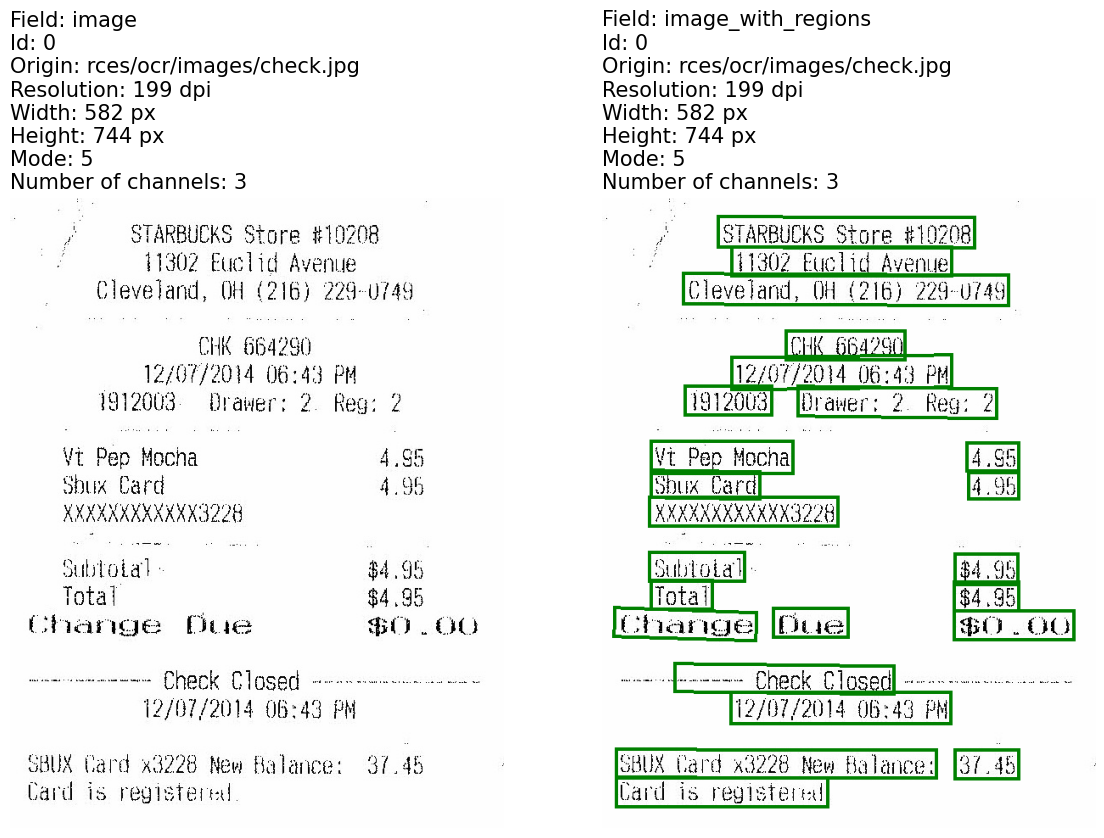

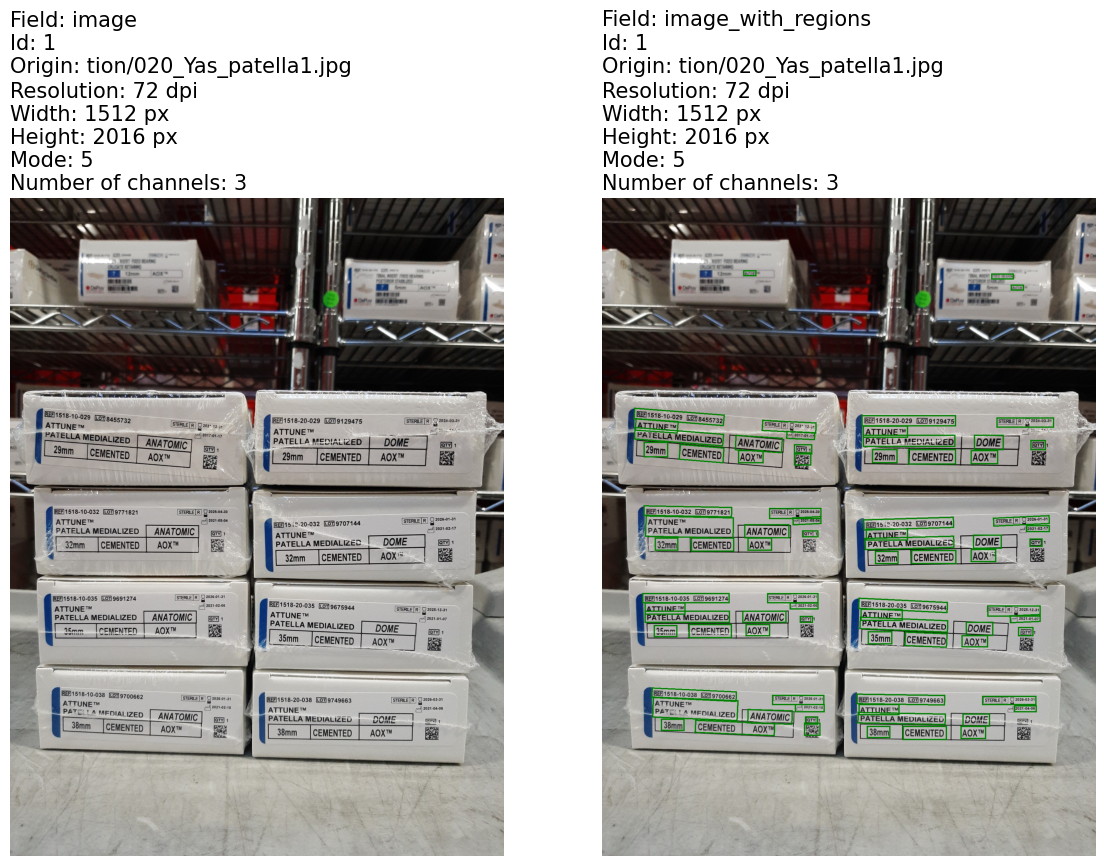

In [10]:
display_images_horizontal(result, "image,image_with_regions")

In [13]:
v2_pipeline.stages[1].setWithRefiner(False)
v2_pipeline.stages[1].setSizeThreshold(15)
v2_pipeline.stages[1].setLinkThreshold(0.3)
v2_pipeline.stages[1].setScoreThreshold(0.7)
v2_pipeline.stages[1].setTextThreshold(0.4)
v2_pipeline.stages[1].setMergeIntersects(False)

result = v2_pipeline.transform(image_df)
result.columns

['text_regions',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'image',
 'image_with_regions',
 'exception']

/usr/local/lib/python3.12/dist-packages/sparkocr/transformers/dicom/dicom_metadata_deidentifier.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
15:01:30, INFO Run ImageTextDetectorV2
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
15:01:34, INFO Run ImageTextDetectorV2
                                              

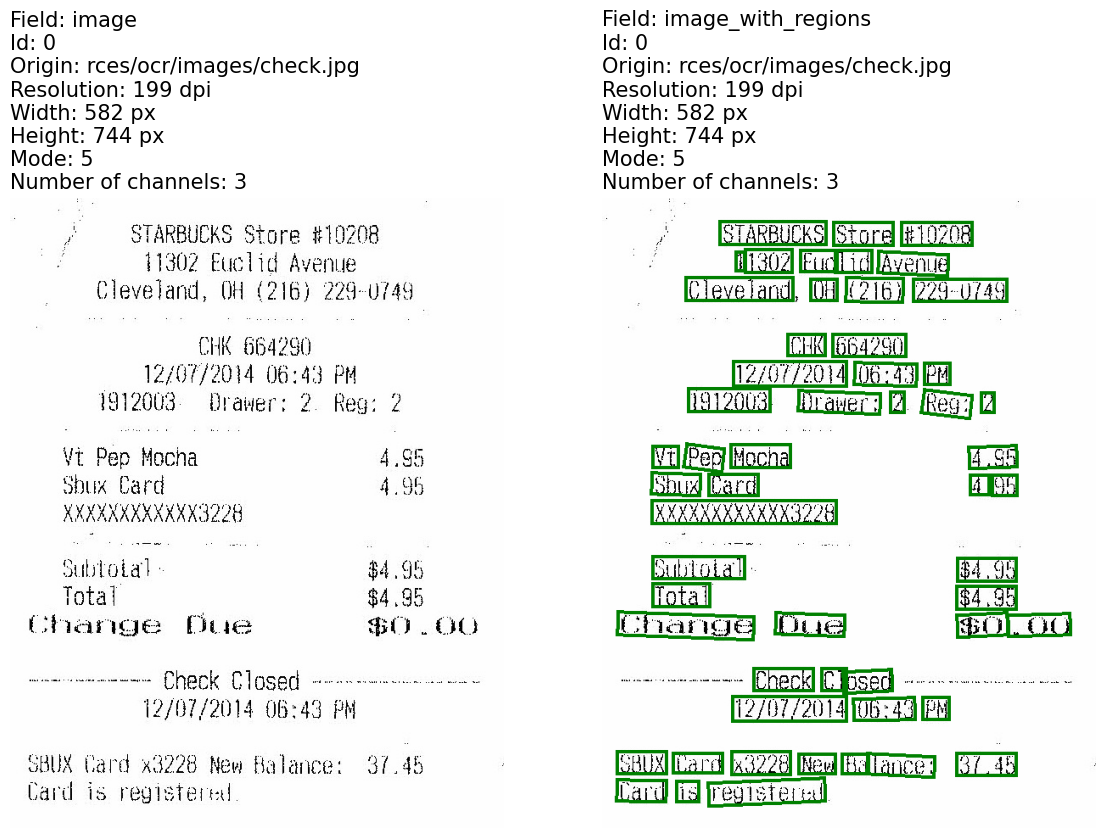

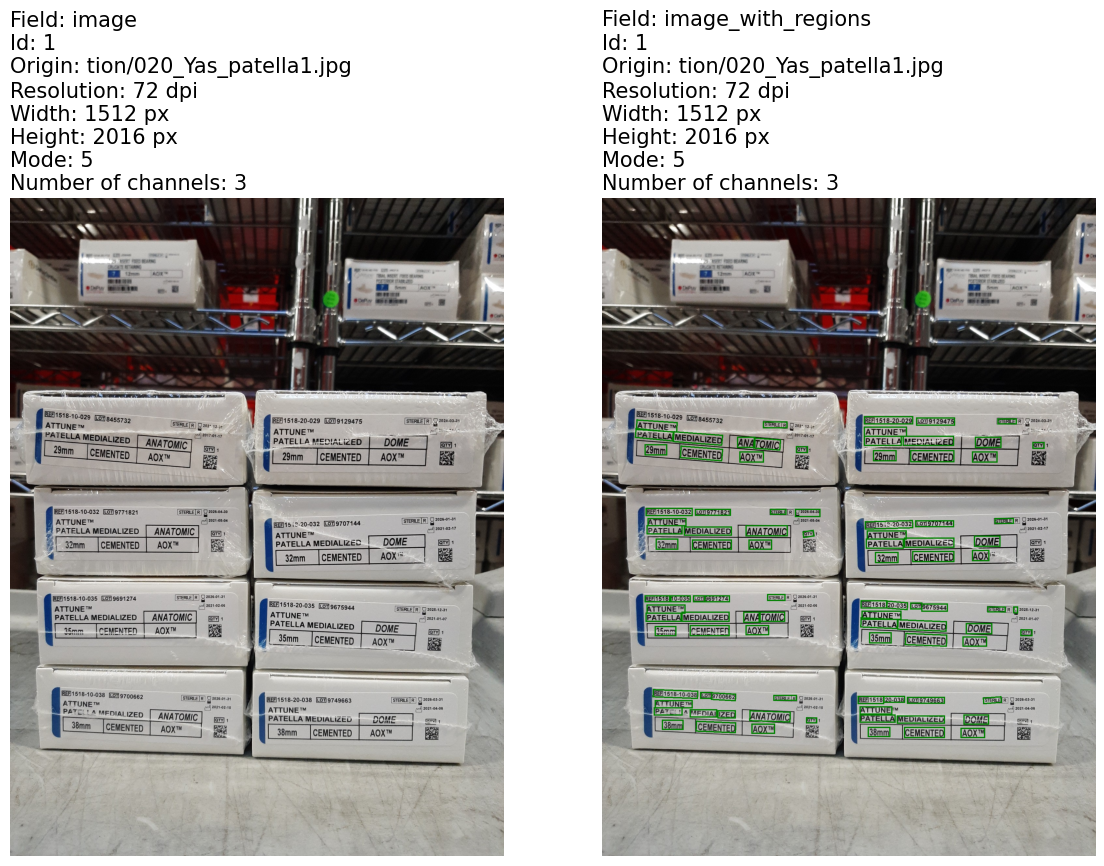

In [14]:
display_images_horizontal(result, "image,image_with_regions")

## ImageTextDetector Parameters

**height** – Height of the input shape. Set to `0` to keep the default value. Can be modified to upscale or downscale the image.  
**width** – Width of the input shape. Set to `0` to keep the default value. Can be modified to upscale or downscale the image.  
**textThreshold** – Determines how confident the model must be that a pixel is at the center of a character.  
**linkThreshold** – Controls the confidence level for connecting nearby character regions.  
**sizeThreshold** – Sets the minimum height for detected text regions.  
**withRefiner** – Enables the refiner network as a post-processing step for improved accuracy.  
**useGPU** – Enables running the model on GPU for faster inference.  
**scoreThreshold** – Score threshold above which detection is considered reliable.

In [15]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetector.pretrained("image_text_detector_opt", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setSizeThreshold(10) \
    .setScoreThreshold(0.85) \
    .setLinkThreshold(0.4) \
    .setTextThreshold(0.2) \
    .setWidth(0) \
    .setHeight(0)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

opt_pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    draw_regions
])

image_text_detector_opt download started this may take some time.


25/10/19 15:05:11 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/19 15:05:11 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/19 15:05:11 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 75.8 MB
image_text_detector_opt download started this may take some time.
Approximate size to download 75.8 MB
Download done! Loading the resource.


In [16]:
result = opt_pipeline.transform(image_df)
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'text_regions',
 'image_with_regions',
 'exception']

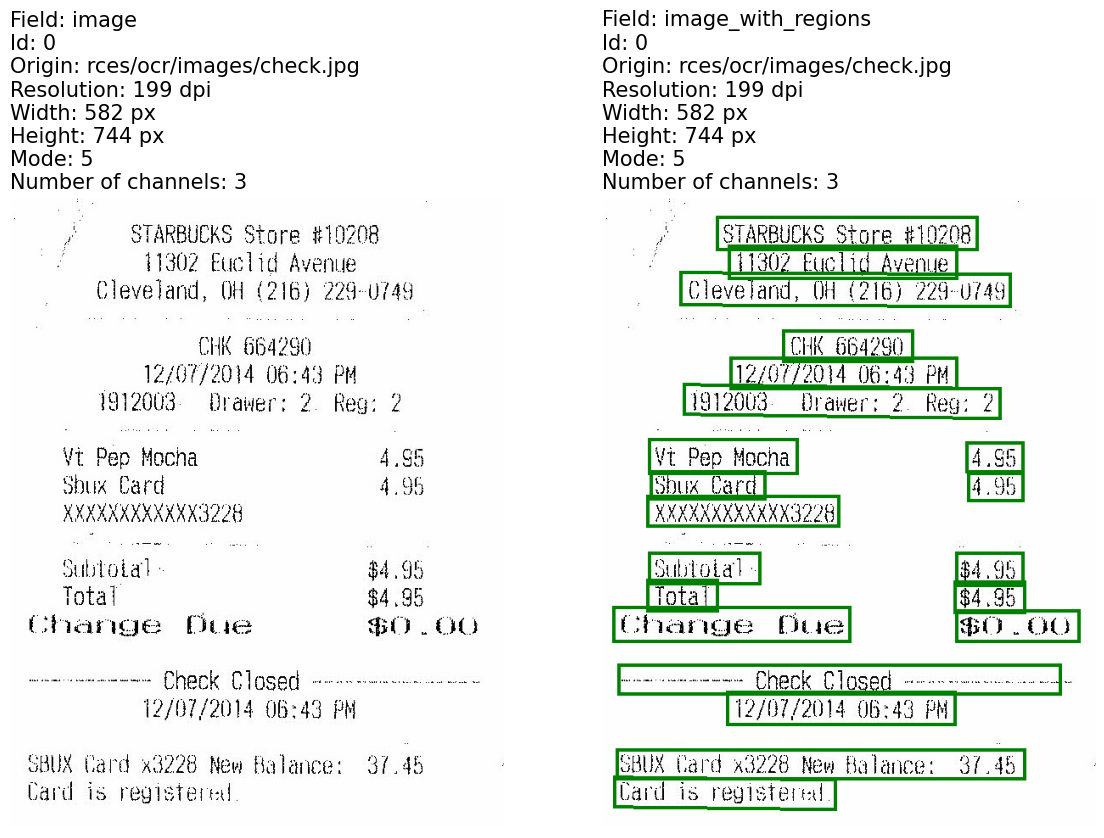

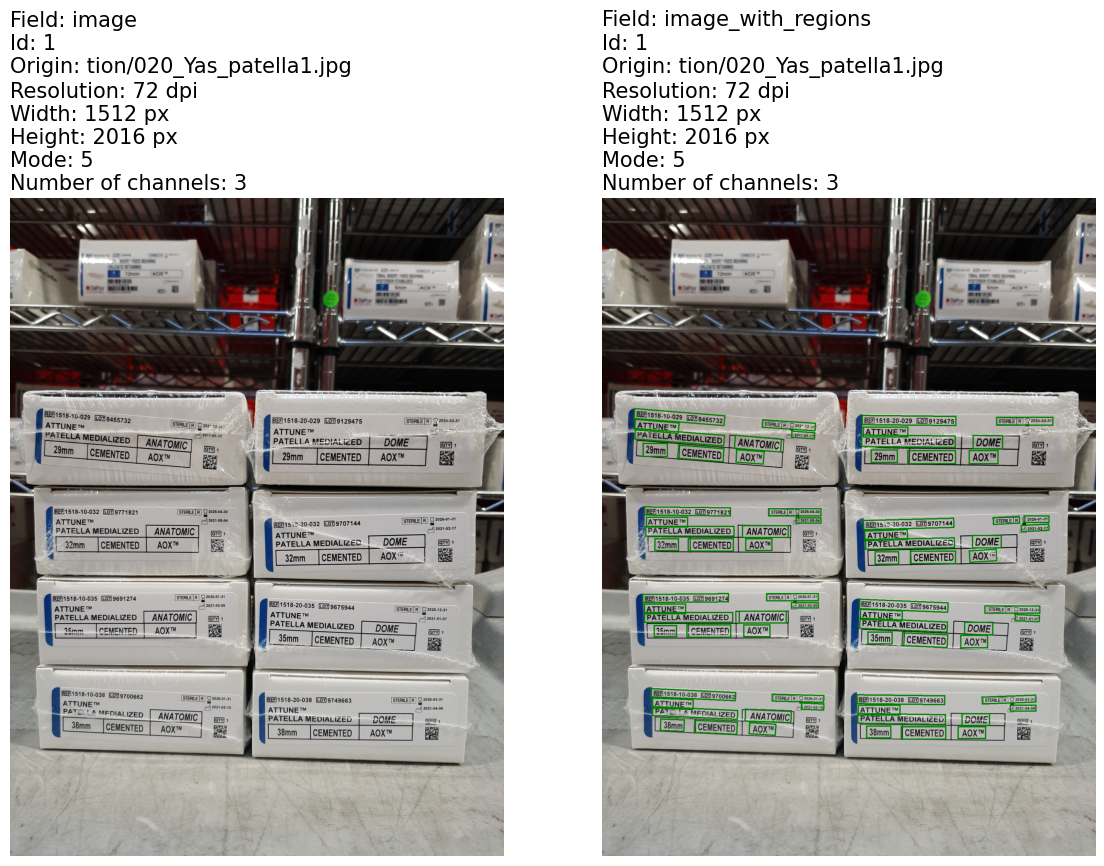

In [17]:
display_images_horizontal(result, "image,image_with_regions")

<h1>PDF Text Detection</h1>

In [18]:
pdf_df = spark.read.format("binaryFile").load("./data/visual/pdfs/PDF_Deid_Deidentification_0.pdf")
pdf_df.columns

['path', 'modificationTime', 'length', 'content']

In [19]:
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetector.pretrained("image_text_detector_opt", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setSizeThreshold(10) \
    .setScoreThreshold(0.85) \
    .setLinkThreshold(0.4) \
    .setTextThreshold(0.2) \
    .setWidth(0) \
    .setHeight(0)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

opt_pipeline = PipelineModel(stages=[
    pdf_to_image,
    text_detector,
    draw_regions
])

image_text_detector_opt download started this may take some time.
Approximate size to download 75.8 MB


25/10/19 15:06:31 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


In [20]:
result = opt_pipeline.transform(pdf_df)
result.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'text_regions',
 'image_with_regions',
 'exception']

25/10/19 15:06:53 WARN FileSystemFontProvider: New fonts found, font cache will be re-built
25/10/19 15:06:53 WARN FileSystemFontProvider: Building on-disk font cache, this may take a while
25/10/19 15:06:53 WARN FileSystemFontProvider: Finished building on-disk font cache, found 22 fonts
25/10/19 15:06:53 WARN PDType1Font: Using fallback font LiberationSans for base font Times-Roman
25/10/19 15:06:53 WARN PDType1Font: Using fallback font LiberationSans for base font Times-Bold
25/10/19 15:06:53 WARN PDType1Font: Using fallback font LiberationSans for base font Times-Italic
25/10/19 15:06:53 WARN PDType1Font: Using fallback font LiberationSans for base font Times-BoldItalic
25/10/19 15:06:53 WARN PDType1Font: Using fallback font LiberationSans for base font Helvetica
25/10/19 15:06:53 WARN PDType1Font: Using fallback font LiberationSans for base font Helvetica-Bold
25/10/19 15:06:53 WARN PDType1Font: Using fallback font LiberationSans for base font Helvetica-Oblique
25/10/19 15:06:53 W

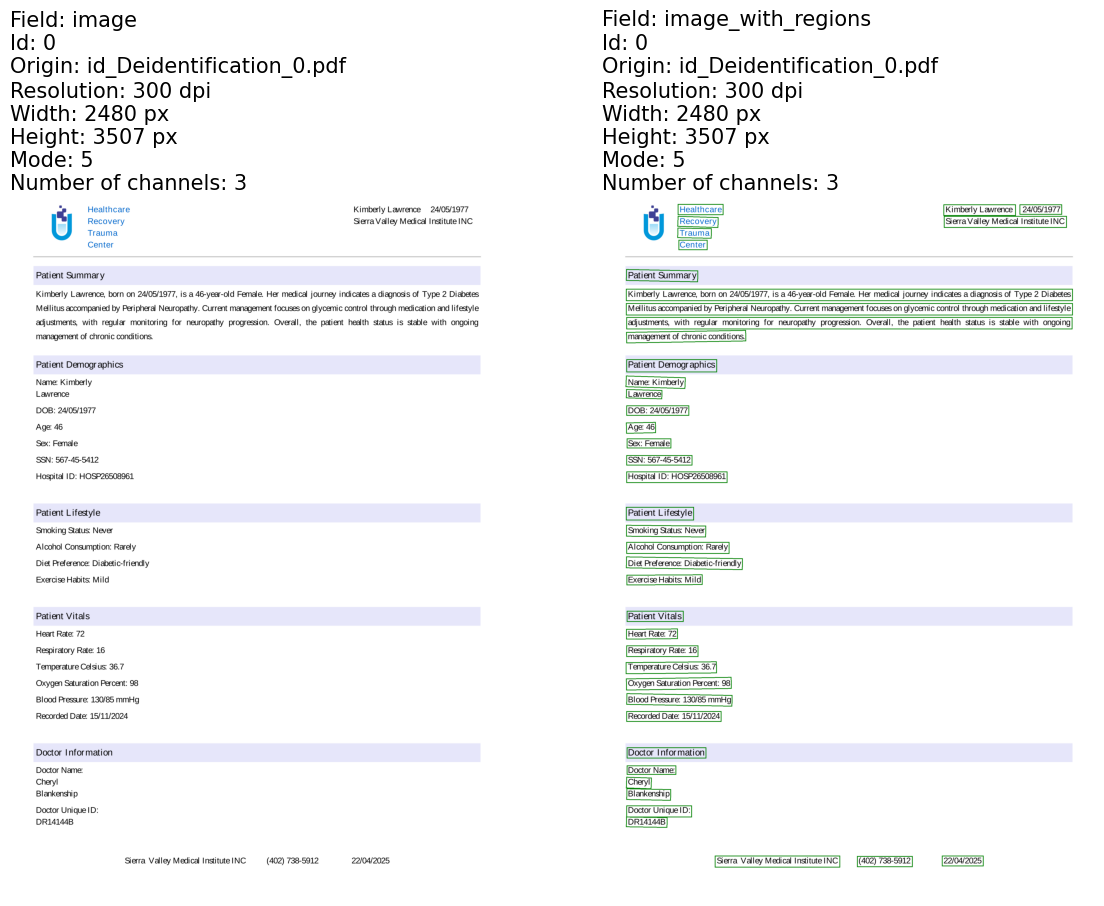

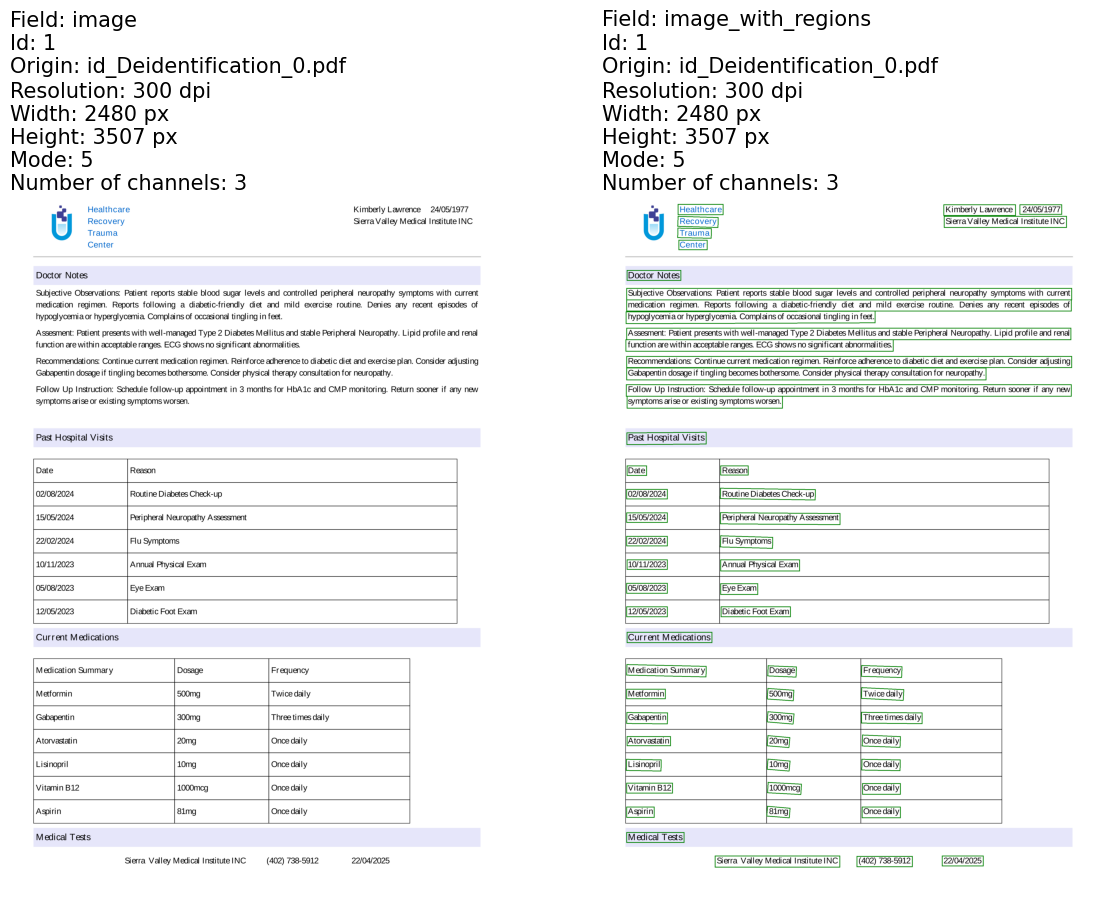

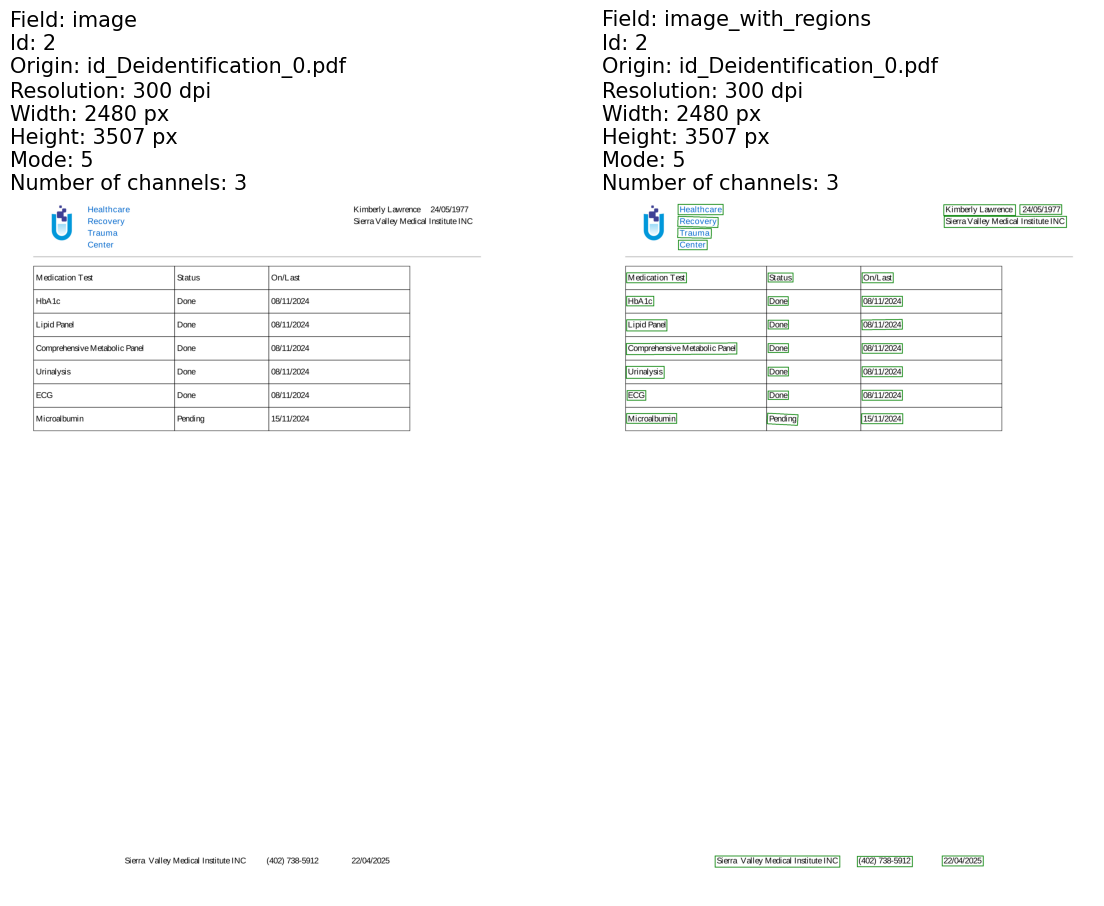

In [21]:
display_images_horizontal(result.orderBy("pagenum"), "image,image_with_regions")